In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import sys
from pathlib import Path
import xarray as xr
import cfgrib
import cartopy.crs as ccrs  # Projeções de mapas.
import cartopy.feature as cfeature  # Elementos geográficos.
from matplotlib.tri import Triangulation

#Import local libraries
import aux

In [2]:
year='2018'
month='12'
month_abbr = datetime.datetime.strptime(month, "%m").strftime("%b")

base_dir='/pesq/dados/monan/users/madeleine.gacita/global_data/'

In [3]:
rad_var_dict={
    "ISR": {
        "era5_name" : "ssrd",
        "era5_longname" :"surface_solar_radiation_downwards",
        "ceres_name" : "init_all_sfc_sw_dn", 
        "monan_name" : "swdnb",
        "unit" : "W m^{-2}",
        "label" : "Surface shortwave radiation downwards",
        "vmin" : 0,
        "24vmin" : 0,
        "vmax" : 1300,
        "24vmax" : 8000
    },
    "ISRC": {
        "era5_name" : "ssrdc",
        "era5_longname" :"surface_solar_radiation_downward_clear_sky",
        "ceres_name" : "init_clr_sfc_sw_dn", 
        "monan_name" : "swdnbc",
        "unit" : "W m^{-2}",
        "label" : "Surface shortwave radiation downwards (clear sky)",
        "vmin" : 0,
        "24vmin" : 0,
        "vmax" : 1300,
        "24vmax" : 8000
    },
    "OLR": {
        "era5_name": "ttr",
        "era5_longname" :"top_net_thermal_radiation",
        "ceres_name" : "init_all_toa_lw_up", 
        "monan_name" : "lwupt",
        "unit" : "W m^{-2}",
        "label" : "TOA Outgoing longwave radiation",
        "24vmin" : -400,
        "24vmin" : -3000,
        "24vmax" : 0,
        "24vmax" : 0
    },
    "OLRC": {
        "era5_name" : "ttrc",
        "era5_longname" : "top_net_thermal_radiation_clear_sky",
        "ceres_name" : "init_clr_toa_lw_up", 
        "monan_name" : "lwuptc",
        "unit" : "W m^{-2}",
        "label" : "TOA Outgoing longwave radiation (clear sky)",
        "vmin" : -400,
        "24vmin" : -3000,
        "vmax" : 0,
        "24vmax" : 0
    },
    "TISR": {
        "era5_name" : "tisr",
        "era5_longname" : "toa_incident_solar_radiation",
        "ceres_name" : "toa_sw_insol", 
        "monan_name" : "swdnt",
        "unit" : "W m^{-2}",
        "label" : "TOA incident short-wave (solar) radiation",
        "vmin" : 0,
        "24vmin" : 0,
        "vmax" : 1300,
        "24vmax" : 8000
    }
}

surf_flux_dict={
    "HF": {
        "era5_name" : "sshf",
        "era5_longname" : "surface_sensible_heat_flux",
        "monan_name" : "hfx", 
        "unit" : "W/m**2",
        "label" : "Sensible heat flux"
    },
    "LF": {
        "era5_name": "sslf",
        "era5_longname":"surface_latent_heat_flux",
        "monan_name": "lf", 
        "unit": "W m^{-2}",
        "label": "Latent heat flux"
    }
}

profile_vars_dict={
    "ISR": {
        "monan_name" : "ssrd",
        "ceres_name" : "adj_all_sw_dn",
        "unit" : "W m^{-2}",
        "label" : "Incoming shortwave radiation"
    },
    "OSR": {
        "monan_name" : "ssrd",
        "ceres_name" : "adj_all_sw_up", 
        "unit" : "W m^{-2}",
        "label" : "Outgoing shortwave radiation"
    },
    "ILR": {
        "monan_name" : "ttrc",
        "ceres_name" : "adj_all_lw_dn", 
        "unit" : "W m^{-2}",
        "label" : "Incoming longwave radiation"
    },
    "OLR": {
        "monan_name" : "ttr",
        "ceres_name" : "adj_all_lw_up", 
        "unit" : "W m^{-2}",
        "label" : "Outgoing longwave radiation"
    }    
}

In [4]:
def apply_lon_lat_conventions(ds):
    # Renames
    if "lon" in ds.dims:
        ds = ds.rename({"lon": "longitude"})
    if "lat" in ds.dims:
        ds = ds.rename({"lat": "latitude"})
 
    # Flip latitudes (ensure they are monotonic increasing)
    if "latitude" in ds.dims:
        lats = ds["latitude"]
        if len(lats) > 1 and lats[0] > lats[-1]:
            ds = ds.reindex(latitude=ds.latitude[::-1])
 
    # Convert longitude to [-180, 180[
    if "longitude" in ds.dims and ds["longitude"].max() > 180:
        lons = ds["longitude"]
        lons_attrs = lons.attrs
        new_lons = np.concatenate([lons[lons >= 180], lons[lons < 180]])
        ds = ds.reindex(longitude=new_lons)
        ds = ds.assign_coords(longitude=(((ds["longitude"] + 180) % 360) - 180))
        ds["longitude"].attrs = lons_attrs
    return ds

# Opening CERES SYN_1deg Ed A

In [5]:
syn_file_arg = base_dir+"CER_SYN1deg-MHour/Terra-Aqua-MODIS_Edition4A/CER_SYN1deg-MHour_Terra-Aqua-MODIS_Edition4A_407406."+year+month+".hdf"
path = Path(syn_file_arg)
print(syn_file_arg)

if not path.exists():
    print(f"File does not exist: {path!s}")
else:
    from pyhdf.SD import SD, SDC
    sd = SD(str(path), SDC.READ)
    print("pyhdf.SD opened file — datasets:")
    names = list(sd.datasets().keys())


/pesq/dados/monan/users/madeleine.gacita/global_data/CER_SYN1deg-MHour/Terra-Aqua-MODIS_Edition4A/CER_SYN1deg-MHour_Terra-Aqua-MODIS_Edition4A_407406.201812.hdf
pyhdf.SD opened file — datasets:


# Surface shortwave radiation downwards

### Plots general settings

In [6]:
var="ISR"
flux_var_name = f'{rad_var_dict[var]["era5_name"]}_flux'
fig_path="/pesq/dados/monan/users/madeleine.gacita/figuras_rodada/"

UTC_hour_plot=15
target_lon = -60.0

## Opening MONAN data and extracting {var}

In [9]:
monan_dir="/pesq/dados/monan/users/lianet.hernandez/global_clm_2018-2019/derived_data/"

# monan_diag=f"MONAN_DIAG_G_MOD_GFS_2018111500_{year}{month}{day}{hour}.00.00.x655362L55.nc"
monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{rad_var_dict[var]["monan_name"]}_MHourly.nc'

monan_path = Path(monan_file)

ds_monan = xr.open_dataset(monan_path, engine="h5netcdf")
# Adjusting sign of OLR / OLRC as negative outgoing
if var=="OLR" or var=="OLRC":
    ds_monan[rad_var_dict[var]['monan_name']] = 0 - ds_monan[rad_var_dict[var]['monan_name']]


monan_lons=ds_monan['lon']
monan_lats=ds_monan['lat']

print(ds_monan)

<xarray.Dataset> Size: 199MB
Dimensions:     (hour: 24, nCells: 655362)
Coordinates:
  * hour        (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
    lat         (nCells) float64 5MB ...
    lon         (nCells) float64 5MB ...
Dimensions without coordinates: nCells
Data variables:
    local_hour  (hour, nCells) timedelta64[ns] 126MB ...
    swdnb       (hour, nCells) float32 63MB ...


### Plotting for {UTC_hour_plot}

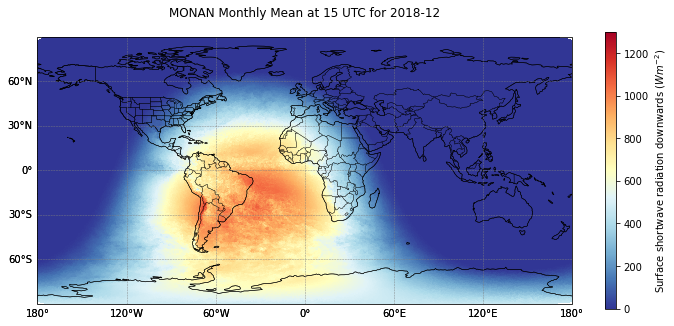

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_ISR_2018_12_15.png


In [10]:
# Create triangulation
tri = Triangulation(monan_lons, monan_lats)

monan_data_sel_time = ds_monan[rad_var_dict[var]['monan_name']].where(ds_monan['hour'] == UTC_hour_plot, drop=True)[0]


    
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot
tpc = ax.tripcolor(
    tri, monan_data_sel_time, 
    cmap="RdYlBu_r", 
    shading="flat",
    vmin=rad_var_dict[var]['vmin'],
    vmax=rad_var_dict[var]['vmax']
    )
plt.colorbar(tpc, label= f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"MONAN Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
out_png = f"{fig_path}/MONAN_{var}_{year}_{month}_{UTC_hour_plot}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

### Plotting 24h accumulated

In [11]:
monan_data_accum = ds_monan[rad_var_dict[var]['monan_name']].sum(dim='hour')
print(monan_data_accum.values.min())
print(monan_data_accum.values.max())

0.0
11516.714


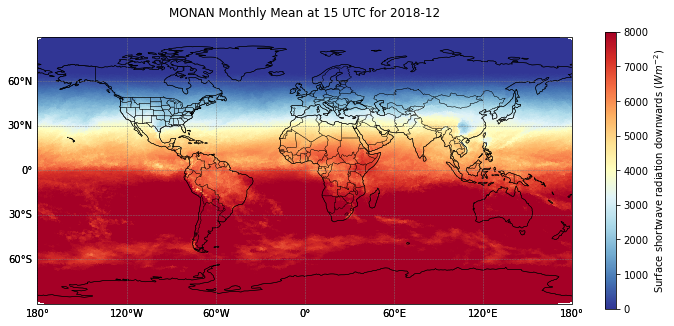

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_ISR_2018_12_24accum.png


In [12]:
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot
tpc = ax.tripcolor(
    tri, monan_data_accum, 
    cmap="RdYlBu_r", 
    shading="flat",
    vmin=rad_var_dict[var]['24vmin'],
    vmax=rad_var_dict[var]['24vmax']
    )
plt.colorbar(tpc, label= f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"MONAN Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
out_png = f"{fig_path}/MONAN_{var}_{year}_{month}_24accum.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

## Extracting CERES {var} data from opened file

In [13]:
var_names = [rad_var_dict[var]['ceres_name']]
CER_data_dict = {}
for desired in var_names:
    target = None
    for n in names:
        if n == desired or desired in n:
            target = n
            break
    if target is None:
        print(f"Dataset '{desired}' not found in the file. Available datasets: {names[:20]}")
    else:
        print(f"Reading dataset: {target}")
        sds = sd.select(target)
        try:
            CER_data = sds.get()              
            print(f"{desired} shape: {CER_data.shape}, dtype: {CER_data.dtype}")
            # Apply scale/offset if present in attributes
            try:
                attrs = sds.attributes()
                scale = attrs.get('scale_factor') or attrs.get('scale') or attrs.get('SCALE')
                offset = attrs.get('add_offset') or attrs.get('offset') or attrs.get('OFFSET')
                if scale is not None:
                    CER_data = CER_data * float(scale)
                if offset is not None:
                    CER_data = CER_data + float(offset)
                if var=="OLR" or var=="OLRC":
                #  OLR=-TTR; OLRC=-TTRC
                    CER_data=0-CER_data
            
            except Exception:
                pass
            CER_data_dict[desired] = CER_data
            try:
                sds.end()
            except Exception:
                pass

            # Find longitude and latitude coordinates for georeferenced plotting
            lon_coords = None
            lat_coords = None
            lon_names = [n for n in names if 'lon' in n.lower() or 'longitude' in n.lower()]
            for lname in lon_names:
                try:
                    lds = sd.select(lname)
                    try:
                        lvals = lds.get()
                    except Exception:
                        lvals = lds[:]
                    lon_coords = np.array(lvals)
                    try:
                        lds.end()
                    except Exception:
                        pass
                    break
                except Exception:
                    continue
            lat_names = [n for n in names if 'lat' in n.lower() or 'latitude' in n.lower()]
            for lname in lat_names:
                try:
                    lds = sd.select(lname)
                    try:
                        lvals = lds.get()
                    except Exception:
                        lvals = lds[:]
                    lat_coords = np.array(lvals)
                    try:
                        lds.end()
                    except Exception:
                        pass
                    break
                except Exception:
                    continue
        
        except Exception:
            CER_data = sds[:]  

Reading dataset: init_all_sfc_sw_dn
init_all_sfc_sw_dn shape: (24, 180, 360), dtype: float32


In [14]:
hour_data = sd.select('gmt_hr_index').get()
print(hour_data)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


## Plotting CERES {var} data at {UTC_hour_plot}

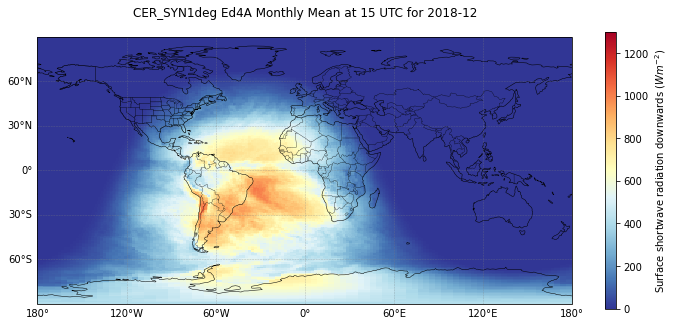

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_ISR_2018_12_15.png


In [15]:
# If data is 3D with time as first dim, plot first time slice
print()

# Select values at hour {UTC_hour_plot}
if UTC_hour_plot==0:
    time_mask = hour_data == 24
else:
    time_mask = hour_data == UTC_hour_plot

# time_sel = time[mask]
# vals_sel = values[mask]

CER_data_sel_time = CER_data[time_mask][0]

    
# Handle 2D or 1D coordinate arrays
if lon_coords.ndim == 2 and lat_coords.ndim == 2:
    X, Y = lon_coords, lat_coords
else:
    X, Y = np.meshgrid(lon_coords, lat_coords)
    
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot the data (sorted by latitude to avoid ValueError)
im = plt.pcolormesh(X, Y, CER_data_sel_time,

    cmap='RdYlBu_r',
    vmin=rad_var_dict[var]['vmin'],
    vmax=rad_var_dict[var]['vmax']
#                     ,
#     cbar_kwargs={
#         'shrink': 0.5,  # Make colorbar 70% of the plot height
#         'aspect': 25,   # Control width (higher = thinner)
#         'pad': 0.05,    # Space between plot and colorbar
#         'label': 'ERA5 Incoming Surface Solar Radiation (W/m²)'
#     }
)
plt.colorbar(im, 
             shrink = 0.5,  # Make colorbar 70% of the plot height
             aspect = 25,   # Control width (higher = thinner)
             pad = 0.05,    # Space between plot and colorbar
             label = f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']})$")

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"CER_SYN1deg Ed4A Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/CER_SYN1deg_Ed4A_{var}_{year}_{month}_{UTC_hour_plot}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")




#### Plotting CERES {var} 24 h accum data 

(180, 360)


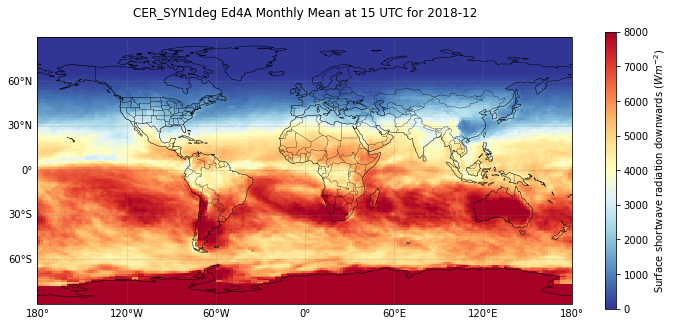

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_ISR_2018_12_24accum.png


In [16]:
# If data is 3D with time as first dim, plot first time slice
# print()

# # Select values at hour {UTC_hour_plot}
# if UTC_hour_plot==0:
#     time_mask = hour_data == 24
# else:
#     time_mask = hour_data == UTC_hour_plot

# time_sel = time[mask]
# vals_sel = values[mask]

CER_data_all_time = np.sum(CER_data, axis=0)
print(CER_data_all_time.shape)
    
# Handle 2D or 1D coordinate arrays
if lon_coords.ndim == 2 and lat_coords.ndim == 2:
    X, Y = lon_coords, lat_coords
else:
    X, Y = np.meshgrid(lon_coords, lat_coords)
    
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot the data (sorted by latitude to avoid ValueError)
im = plt.pcolormesh(X, Y, CER_data_all_time,

    cmap='RdYlBu_r',
    vmin=rad_var_dict[var]['24vmin'],
    vmax=rad_var_dict[var]['24vmax']
#                     ,
#     cbar_kwargs={
#         'shrink': 0.5,  # Make colorbar 70% of the plot height
#         'aspect': 25,   # Control width (higher = thinner)
#         'pad': 0.05,    # Space between plot and colorbar
#         'label': 'ERA5 Incoming Surface Solar Radiation (W/m²)'
#     }
)
plt.colorbar(im, 
             shrink = 0.5,  # Make colorbar 70% of the plot height
             aspect = 25,   # Control width (higher = thinner)
             pad = 0.05,    # Space between plot and colorbar
             label = f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']})$")

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"CER_SYN1deg Ed4A Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/CER_SYN1deg_Ed4A_{var}_{year}_{month}_24accum.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")




## Opening ERA5 {var} data

In [17]:
era5_file_arg = base_dir+f"era5/single_levels/{year}/{month}/{rad_var_dict[var]['era5_longname']}_MHour.nc"
path = Path(era5_file_arg)

ds_era5 = xr.open_dataset(path, engine="netcdf4")
ds_era5 = apply_lon_lat_conventions(ds_era5)

ds_era5[flux_var_name] = ds_era5[rad_var_dict[var]["era5_name"]]/3600
ds_era5[flux_var_name].attrs = {'units': rad_var_dict[var]["unit"]}
ds_era5[flux_var_name].attrs['description'] = f'Instantaneous flux calculated from accumulated {rad_var_dict[var]["era5_name"].upper()}'
print(ds_era5[flux_var_name].attrs)
print(ds_era5['valid_time'])


FileNotFoundError: [Errno 2] No such file or directory: '/pesq/dados/monan/users/madeleine.gacita/global_data/era5/single_levels/2018/12/surface_solar_radiation_downwards_MHour.nc'

## Plotting ERA5 {var} data at {UTC_hour_plot}

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_era5_sel_time = ds_era5.where(ds_era5['valid_time'].dt.hour == UTC_hour_plot, drop=True)

# Plot the data (sorted by latitude to avoid ValueError)
im = ds_era5_sel_time[flux_var_name].plot(
    ax=ax, 
    cmap='RdYlBu_r',
    vmin=rad_var_dict[var]['vmin'],
    vmax=rad_var_dict[var]['vmax'],
    cbar_kwargs={
        'shrink': 0.5,  # Make colorbar 70% of the plot height
        'aspect': 25,   # Control width (higher = thinner)
        'pad': 0.05,    # Space between plot and colorbar
        'label': f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)"
    }
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set title
ax.set_title(f"ERA5 Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/ERA5_{var}_{year}_{month}_{UTC_hour_plot}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')

print(f"Saved plot to: {out_png}")

## Plotting ERA5 {var} 24 h accum data

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_era5_all_time = ds_era5.sum(dim='valid_time')

# Plot the data (sorted by latitude to avoid ValueError)
im = ds_era5_all_time[flux_var_name].plot(
    ax=ax, 
    cmap='RdYlBu_r',
    vmin=rad_var_dict[var]['24vmin'],
    vmax=rad_var_dict[var]['24vmax'],
    cbar_kwargs={
        'shrink': 0.5,  # Make colorbar 70% of the plot height
        'aspect': 25,   # Control width (higher = thinner)
        'pad': 0.05,    # Space between plot and colorbar
        'label': f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)"
    }
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set title
ax.set_title(f"ERA5 Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/ERA5_{var}_{year}_{month}_24accum.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')

print(f"Saved plot to: {out_png}")

## Plotting profile at {UTC_hour_plot} and {target_lon}

### Extract ERA5 Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
#Extract data from ERA5
# Get the data variable at hour {UTC_hour_plot}
era5_data_2d = ds_era5_sel_time[flux_var_name][0]

# Find longitude index closest to target_lon
era5_lon = era5_data_2d['longitude'].values
era5_lon_idx = np.argmin(np.abs(era5_lon - target_lon))
actual_lon = era5_lon[era5_lon_idx]

# Extract slice at that longitude
era5_slice = era5_data_2d.isel(longitude=era5_lon_idx)
era5_lat = era5_slice['latitude'].values
era5_values = era5_slice.values

### Extract CERES Mhourly mean data  at {UTC_hour_plot} and {target_lon} 

In [ ]:
# Get the data variable at hour {UTC_hour_plot}
ceres_data_2d = CER_data_sel_time

# Find longitude index closest to target_lon
ceres_lon_idx = np.argmin(np.abs(lon_coords - target_lon))
actual_ceres_lon = lon_coords[ceres_lon_idx]        

# Extract slice at that longitude
ceres_slice = ceres_data_2d[:,ceres_lon_idx]
ceres_values = ceres_slice

### Extract MONAN Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
#Extract data from CER_CYN1deg        
# Get the data variable at hour {UTC_hour_plot}
monan_data_2d =monan_data_sel_time

# Select longitude = {target_lon} (nearest index)
tol=0.05
mask = np.abs(monan_lons - target_lon) < tol
monan_lat_slice = monan_lats[mask]
monan_slice = monan_data_2d[mask]

# Order by latitude
order = np.argsort(monan_lat_slice)
monan_lat_slice_sorted = monan_lat_slice[order]
monan_slice_sorted = monan_slice[order]


### Create the plot

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(monan_slice_sorted ,monan_lat_slice_sorted, label=f"MONAN", linewidth=2)
plt.plot(era5_values, era5_lat, label=f"ERA5", linewidth=2)
plt.plot(ceres_values, lat_coords, label=f"CERES", linewidth=2)
plt.xlabel(f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']})$")
plt.ylabel('Latitude (°)')
plt.title(f" Monthly Mean of {rad_var_dict[var]['label']} at {UTC_hour_plot} UTC, lon={actual_lon:.2f}°\n{year}-{month}")
plt.grid(True, alpha=0.3)
plt.legend()

# Save the plot
out_png = f"{fig_path}/{var}_{year}{month}_{UTC_hour_plot}UTC_lon{int(actual_lon)}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {out_png}")
plt.show()
plt.close()

## Plotting profile for 24h accum and {target_lon}

### Extract ERA5 Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
#Extract data from ERA5
# Get the data variable at hour {UTC_hour_plot}
era5_data_2d = ds_era5_all_time[flux_var_name]

# Find longitude index closest to target_lon
era5_lon = era5_data_2d['longitude'].values
era5_lon_idx = np.argmin(np.abs(era5_lon - target_lon))
actual_lon = era5_lon[era5_lon_idx]

# Extract slice at that longitude
era5_slice = era5_data_2d.isel(longitude=era5_lon_idx)
era5_lat = era5_slice['latitude'].values
era5_values = era5_slice.values

### Extract CERES Mhourly mean data  at {UTC_hour_plot} and {target_lon} 

In [ ]:
# Get the data variable at hour {UTC_hour_plot}
ceres_data_2d = CER_data_all_time

# Find longitude index closest to target_lon
ceres_lon_idx = np.argmin(np.abs(lon_coords - target_lon))
actual_ceres_lon = lon_coords[ceres_lon_idx]        

# Extract slice at that longitude
ceres_slice = ceres_data_2d[:,ceres_lon_idx]
ceres_values = ceres_slice

### Extract MONAN Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
#Extract data from CER_CYN1deg        
# Get the data variable at hour {UTC_hour_plot}
monan_data_2d =monan_data_accum

# Select longitude = {target_lon} (nearest index)
tol=0.05
mask = np.abs(monan_lons - target_lon) < tol
monan_lat_slice = monan_lats[mask]
monan_slice = monan_data_2d[mask]

# Order by latitude
order = np.argsort(monan_lat_slice)
monan_lat_slice_sorted = monan_lat_slice[order]
monan_slice_sorted = monan_slice[order]


### Create the plot

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(monan_slice_sorted ,monan_lat_slice_sorted, label=f"MONAN", linewidth=2)
plt.plot(era5_values, era5_lat, label=f"ERA5", linewidth=2)
plt.plot(ceres_values, lat_coords, label=f"CERES", linewidth=2)
plt.xlabel(f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']})$")
plt.ylabel('Latitude (°)')
plt.title(f" Monthly Mean of {rad_var_dict[var]['label']} (24 h accum), lon={actual_lon:.2f}°\n{year}-{month}")
plt.grid(True, alpha=0.3)
plt.legend()

# Save the plot
out_png = f"{fig_path}/{var}_{year}{month}_24_accum_lon{int(actual_lon)}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {out_png}")
plt.show()
plt.close()

### Closing MONAN and ERA5 files

In [ ]:
ds_monan.close()
ds_era5.close()

### Closing CERES file

In [ ]:
try:
    sd.end()
except Exception:
    pass